# Common functions

In [1]:
# `nmf` kernel
library(tidyverse)
library(patchwork)
# library(viridis)
library(NMF)
library(Seurat)
source('./helpers/add_metadata.R')


indir <- '/home/ubuntu/data/cxcr4-pdac/combine_samples'
outdir <- '/home/ubuntu/data/cxcr4-pdac/nmf'

if (!dir.exists(outdir)) {
    dir.create(outdir, recursive=T)
}

message_ <- function(...) {
    message(paste0(Sys.time(), ': ', paste(...)))
}

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: pkgmaker

Loading required package: registry

Loading required package: rngtools

Loading required package: cluster

NMF - BioConductor layer [OK] | Shared memory capabilities [NO: bigmemory] | Cores 15/16

  To enable shared memory capabilities, try: install.extras('
NMF
')

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:BiocGenerics’:

    i

In [137]:
# mkdir -p /home/ubuntu/data/cxcr4-pdac/combine_samples
# aws s3 cp s3://cxcr4-pdac/troubleshoot/malig_RNA.RDS /home/ubuntu/data/cxcr4-pdac/combine_samples/malig_RNA.RDS

# conda create -n nmf
# conda activate nmf
# mamba install -n nmf r-essentials r-base r-tidyverse r-seurat r-nmf r-rmpfr r-mixtools r-ggpubr r-irkernel r-viridis \
#     bioconductor-complexheatmap bioconductor-ucell \
#     -c bioconda -c conda-forge -c r
# R -e 'install.packages("GeneNMF")'

In [2]:
malig <- readRDS(file.path(indir, 'malig_RNA.RDS')) %>% add_metadata()

In [3]:
sample_order <- malig@meta.data %>% 
                group_by(orig.ident) %>% 
                summarize(n=n()) %>% 
                arrange(n) %>%
                mutate(index = seq(nrow(.)))
sample_order

orig.ident,n,index
<chr>,<int>,<int>
GM24,33,1
GM22,46,2
GM35,84,3
GM30,153,4
GM29,182,5
GM40,201,6
GM18,234,7
GM21,312,8
GM31,428,9


## Running NMF

No need to re-run this after it's been computed

In [ ]:
# Heavily adapted from Dr Tagore

produce_mat <- function(orig) {
    sub <- subset(malig, subset = orig.ident == orig)
    message_(toString(dim(sub[["RNA"]]@counts)))


    # Now extract the matrix
    all_genes <- rownames(sub[["RNA"]]@counts)
    mito.genes <- grep(pattern = "^MT-", x = all_genes, value = TRUE)
    rbl.genes <- grep(pattern = "^RB-", x = all_genes, value = TRUE)
    rsl.genes <- grep(pattern = "^RS-", x = all_genes, value = TRUE)
    rpl.genes <- grep(pattern = "^RPL-", x = all_genes, value = TRUE)
    rbl.genes <- grep(pattern = "^RBL-", x = all_genes, value = TRUE)
    rps.genes <- grep(pattern = "^RPS-", x = all_genes, value = TRUE)
    rbs.genes <- grep(pattern = "^RBS-", x = all_genes, value = TRUE)
    rbl1.genes <- grep(pattern = "^RB", x = all_genes, value = TRUE)
    rsl1.genes <- grep(pattern = "^RS", x = all_genes, value = TRUE)
    rpl1.genes <- grep(pattern = "^RPL", x = all_genes, value = TRUE)
    rbl1.genes <- grep(pattern = "^RBL", x = all_genes, value = TRUE)
    rps1.genes <- grep(pattern = "^RPS", x = all_genes, value = TRUE)
    rbs1.genes <- grep(pattern = "^RBS", x = all_genes, value = TRUE)

    remove_list <- c(
        mito.genes, rbl.genes, rsl.genes, rpl.genes, rbl.genes,
        rps.genes, rbs.genes, rbl1.genes, rsl1.genes, rpl1.genes,
        rbl1.genes, rps1.genes, rbs1.genes
    )

    # Taking top 7k genes by mean expression
    good_genes <- rowSums(sub[["RNA"]]@counts) %>%
        sort(decreasing = T) %>%
        as.data.frame() %>%
        rownames_to_column("gene") %>%
        filter(!(gene %in% remove_list)) %>%
        head(7000) %>%
        .$gene
    seu <- subset(sub, features = good_genes)

    seu <- NormalizeData(seu, normalization.method = "LogNormalize", scale.factor = 10000)
    # seu <- FindVariableFeatures(seu, selection.method = "vst", nfeatures = 2000)
    # seu <- ScaleData(seu, features = rownames(seu))

    mat <- as.matrix(seu@assays$RNA@data)
    mat <- mat[rowSums(mat) > 0, ]

    message_("Generated matrix for", orig)
    message_(toString(dim(seu[["RNA"]]@counts)))
    return(mat)
}


ct <- 0

# First run just to initialize all possible matrices
for (orig in sample_order$orig.ident) {
    ct <- ct + 1
    if (ct %% 4 != 1) next() # TODO: EDIT BASED ON WHICH MACHINE IT'S RUNNING

    # outfile <- file.path(outdir, paste0(orig, '.pdf'))
    sample_outdir <- file.path(outdir, orig)
    if (!dir.exists(sample_outdir)) {
        dir.create(sample_outdir, recursive = T)
    }
    estim_outdir <- file.path(outdir, "all_ranks")
    if (!dir.exists(estim_outdir)) {
        dir.create(estim_outdir, recursive = T)
    }


    ranks <- c(2, 3, 4, 5, 6, 7, 8)
    outfiles <- lapply(
        ranks,
        function(x) {
            file.path(
                sample_outdir,
                paste0(orig, "_r", x, ".RDS")
            )
        }
    )
    names(outfiles) <- ranks
    rank_estim_rds <- file.path(estim_outdir, paste0(orig, "_all.RDS"))
    rank_estim_pdf <- file.path(estim_outdir, paste0(orig, ".pdf"))


    message_(orig)

    # For the individual rank calculationss
    donefile <- file.path(sample_outdir, "done.checkpoint")
    if (!file.exists(donefile)) {
        mat <- produce_mat(orig)

        # Individual NMF ranks
        for (rank in ranks) {
            t_0 <- Sys.time()
            message_("Starting individual NMF for", orig, "rank", rank)

            if (!file.exists(outfiles[[as.character(rank)]])) {
                # For 2700 cells, took between 1.5-2h at rank 7
                # Optimistic estimate of 12ish hours for full estimate
                # assuming the 10 runs are perfectly run in parallel
                res <- nmf(mat,
                    rank,
                    method = "brunet",
                    nrun = 10,
                    seed = 123456,
                    rng = 123456,
                    .opt = "v"
                )
                saveRDS(res, outfiles[[as.character(rank)]])
            }

            t_1 <- Sys.time()
            message_(
                "Done with individual NMF for", orig, "rank", rank,
                ". Elapsed time: ", t_1 - t_0
            )
        }
    } else {
        message_("Already done with individual NMFs for", orig)
    }
    file.create(donefile)


    # For the rank estimation

    if (!file.exists(rank_estim_rds)) {
        message_("Now running rank estimation for", orig)

        mat <- produce_mat(orig)

        res <- nmf(mat,
            ranks,
            method = "brunet",
            nrun = 10,
            seed = 123456,
            rng = 123456,
            .opt = "v"
        )
        saveRDS(res, rank_estim_rds)
        message_("Finished rank estimation for", orig)
    } else {
        message_("Already done with rank estimation for", orig)
    }

    message_("Fully done with", orig)
}

# Failed at GM36, GM27, GM20, GM26 which were rerun with nrun=5


2024-02-23 21:33:44.300182: GM24

2024-02-23 21:33:44.305263: Already done with individual NMFs for GM24

2024-02-23 21:33:44.30699: Already done with rank estimation for GM24

2024-02-23 21:33:44.308496: Fully done with GM24

2024-02-23 21:33:44.310109: GM29

2024-02-23 21:33:44.311551: Already done with individual NMFs for GM29

2024-02-23 21:33:44.313038: Already done with rank estimation for GM29

2024-02-23 21:33:44.314459: Fully done with GM29

2024-02-23 21:33:44.315974: GM31

2024-02-23 21:33:44.317436: Already done with individual NMFs for GM31

2024-02-23 21:33:44.318886: Already done with rank estimation for GM31

2024-02-23 21:33:44.320389: Fully done with GM31

2024-02-23 21:33:44.321969: GM20

2024-02-23 21:33:44.323379: Already done with individual NMFs for GM20

2024-02-23 21:33:44.324836: Already done with rank estimation for GM20

2024-02-23 21:33:44.326257: Fully done with GM20

2024-02-23 21:33:44.3278: GM37

2024-02-23 21:33:44.329249: Already done with individual 

In [ ]:
# Run this line on all the worker machines to push to s3
# for folder in $(ls /home/ubuntu/data/cxcr4-pdac/nmf | grep "GM"); do echo $folder; aws s3 cp /home/ubuntu/data/cxcr4-pdac/nmf/$folder s3://cxcr4-pdac/nmf/$folder --recursive; done
# aws s3 cp /home/ubuntu/data/cxcr4-pdac/nmf/all_ranks/ s3://cxcr4-pdac/nmf/all_ranks/ --recursive

# Now run this line to sync back to the main machine
# for folder in $(aws s3 ls s3://cxcr4-pdac/nmf/ | awk '{print $2}' | grep "GM" | tr -d "/"); do echo $folder; aws s3 cp s3://cxcr4-pdac/nmf/$folder/ /home/ubuntu/data/cxcr4-pdac/nmf/$folder/ --recursive; done
# aws s3 cp s3://cxcr4-pdac/nmf/all_ranks/ /home/ubuntu/data/cxcr4-pdac/nmf/all_ranks/ --recursive

In [ ]:
# Now to make the consensus maps, which are for some reason
# more likely to crash during execution.
# I'm running consensusmaps on each rank individually rather than
# running it on the NMF Estimate object, which tends to crash

ranks <- c(2, 3, 4, 5, 6, 7, 8)

for (sample in sample_order$orig.ident) {
  outfile <- file.path(
    "/home/ubuntu/data/cxcr4-pdac/nmf",
    "all_ranks", paste0(sample, ".pdf")
  )

  sample_indir <- file.path("/home/ubuntu/data/cxcr4-pdac/nmf/", sample)

  rds_files <- c(file.path(sample_indir, paste0(sample, "_r", ranks, ".RDS")))
  objects <- lapply(rds_files, readRDS)

  estim_res <- readRDS(file.path(
    "/home/ubuntu/data/cxcr4-pdac/nmf/all_ranks",
    paste0(sample, "_all.RDS")
  ))

  # Running individual ranks
  message_("Plotting consensus maps for ", sample)
  pdf(outfile, height = 15, width = 20)
  print(plot(estim_res))
  for (myrank in ranks) {
    # Modified from the consensusmap source code in `NMF` package
    # For whatever reason, the base `consensusmap` function sometimes
    # crashes silently and without throwing errors, causing the loop
    # to terminate prematurely without error. This replicates most of the
    # functionality we desire.

    sil <- function(o) {
      si <- silhouette(o, what = "consensus", order = NA)
      if (is_NA(si)) {
        NA
      } else {
        si[, "sil_width"]
      }
    }
    ann_col <- list(
      basis = predict(objects[[myrank - 1]]),
      consensus = predict(objects[[myrank - 1]], what = "consensus"),
      silhouette = sil(objects[[myrank - 1]])
    )

    aheatmap(consensus(objects[[myrank - 1]]),
      distfun = function(x) as.dist(1 - x),
      hclustfun = "average", color = "-RdYlBu",
      Rowv = T, Colv = T, main = paste0(sample, " rank ", myrank),
      annCol = ann_col,
      labCol = NA, labRow = NA
    )
  }
  dev.off()
}


2023-12-27 19:49:49.412323: Plotting consensus maps for  GM24

2023-12-27 19:49:51.872774: Plotting consensus maps for  GM22

2023-12-27 19:49:54.761229: Plotting consensus maps for  GM35

2023-12-27 19:49:59.023964: Plotting consensus maps for  GM30

2023-12-27 19:50:05.880436: Plotting consensus maps for  GM29

2023-12-27 19:50:14.09058: Plotting consensus maps for  GM40

2023-12-27 19:50:23.463966: Plotting consensus maps for  GM18

2023-12-27 19:50:33.693157: Plotting consensus maps for  GM21

2023-12-27 19:50:47.326694: Plotting consensus maps for  GM31

2023-12-27 19:51:08.192224: Plotting consensus maps for  GM32

2023-12-27 19:51:39.809568: Plotting consensus maps for  GM36

2023-12-27 19:52:12.909683: Plotting consensus maps for  GM27

2023-12-27 19:53:14.558624: Plotting consensus maps for  GM20

2023-12-27 19:54:23.542065: Plotting consensus maps for  GM39

2023-12-27 19:56:32.99063: Plotting consensus maps for  GM26

2023-12-27 19:58:45.659916: Plotting consensus maps for  

In [ ]:
# Create all the CSVs and plots
library(tidyverse)
library(NMF)
ranks <- c(2, 3, 4, 5, 6, 7, 8)

for (sample in sample_order$orig.ident) {
  sample_outdir <- file.path("/home/ubuntu/data/cxcr4-pdac/nmf", sample)


  rds_files <- c(file.path(sample_outdir, paste0(sample, "_r", ranks, ".RDS")))
  objects <- lapply(rds_files, readRDS)

  # Running individual ranks
  for (myrank in ranks) {
    rank_outdir <- file.path(sample_outdir, paste0("rank_", myrank))
    if (!dir.exists(rank_outdir)) {
      dir.create(rank_outdir, recursive = T)
    }
    message_("Sample", sample, "rank", myrank)

    res <- objects[[myrank - 1]]

    write.csv(res@fit@W, file.path(rank_outdir, paste0(sample, "_rank_", myrank, "_W.csv")))
    write.csv(res@fit@H, file.path(rank_outdir, paste0(sample, "_rank_", myrank, "_H.csv")))

    for (top_n in c(30, 50, 100, 200, 300)) {
      tab <- matrix(NA, top_n, myrank)
      colnames(tab) <- paste0(sample, "_factor", seq(1:myrank))
      for (c in 1:myrank) {
        genes <- order(as.data.frame(res@fit@W)[, c], decreasing = T) %>% head(n = top_n)
        tab[, c] <- rownames(as.data.frame(res@fit@W))[genes]
        colnames(tab)[c] <- paste0(sample, "_factor", c)
      }
      write.csv(tab, file.path(rank_outdir, paste0(sample, "_rank_", myrank, "_top_", top_n, ".csv")))

      pdf(file.path(rank_outdir, paste0(sample, "_rank_", myrank, "_top_", top_n, "_basismap.pdf")))
      basismap(res[rownames(res) %in% as.character(tab), ])
      dev.off()
    }
  }
}


2024-02-23 21:33:44.455071: Sample GM24 rank 2



2024-02-23 21:33:46.422483: Sample GM24 rank 3

2024-02-23 21:33:48.286839: Sample GM24 rank 4

2024-02-23 21:33:50.929969: Sample GM24 rank 5

2024-02-23 21:33:53.699615: Sample GM24 rank 6

2024-02-23 21:33:56.924351: Sample GM24 rank 7

2024-02-23 21:34:00.641599: Sample GM24 rank 8

2024-02-23 21:34:04.982548: Sample GM22 rank 2

2024-02-23 21:34:06.381765: Sample GM22 rank 3

2024-02-23 21:34:08.422351: Sample GM22 rank 4

2024-02-23 21:34:10.858493: Sample GM22 rank 5

2024-02-23 21:34:13.724286: Sample GM22 rank 6

2024-02-23 21:34:17.171305: Sample GM22 rank 7

2024-02-23 21:34:21.298559: Sample GM22 rank 8

2024-02-23 21:34:26.264535: Sample GM35 rank 2

2024-02-23 21:34:27.810284: Sample GM35 rank 3

2024-02-23 21:34:29.7851: Sample GM35 rank 4

2024-02-23 21:34:32.18014: Sample GM35 rank 5

2024-02-23 21:34:34.965242: Sample GM35 rank 6

2024-02-23 21:34:38.037046: Sample GM35 rank 7

2024-02-23 21:34:41.687387: Sample GM35 rank 8

2024-02-23 21:34:45.81783: Sample GM30 rank

In [ ]:
# Push to aws server
# aws s3 cp /home/ubuntu/data/cxcr4-pdac/nmf/ s3://cxcr4-pdac/nmf/ --recursive

# Analysis

## Consensus programs

In [4]:
# `nmf kernel`; first load common functions
library(circlize)
library(ComplexHeatmap)
library(cluster)


# Looked at the output PDFs and manually decided optimal ranks
optimal_ranks <- list(
    "GM18" = 2,
    "GM19" = 4,
    "GM20" = 6,
    "GM21" = 3,
    "GM22" = 6,
    "GM23" = 3,
    "GM24" = 5,
    "GM26" = 3,
    "GM27" = 3,
    "GM28" = 4,
    "GM29" = 2,
    "GM30" = 3,
    "GM31" = 4,
    "GM32" = 3,
    "GM33" = 4,
    # No GM34 in malig compartment
    "GM35" = 6, 
    "GM36" = 3, 
    "GM37" = 5,
    "GM38" = 4,
    "GM39" = 5,
    "GM40" = 2 
)

source("./helpers/color.R")

# Now load the optimal rank W files for each sample
nmf_dir <- "/home/ubuntu/data/cxcr4-pdac/nmf"
samples <- names(optimal_ranks)

datafiles <- list()
for (smpl in samples) {
    r <- optimal_ranks[[smpl]]
    indir <- file.path(nmf_dir, smpl, paste0("rank_", r))
    infile <- file.path(indir, paste0(smpl, "_rank_", r, "_W", ".csv"))
    data <- read.csv(infile, row.names = 1)

    column_names <- paste0(smpl, "_r", r, "_f", 1:r)
    colnames(data) <- column_names
    datafiles[[smpl]] <- data %>% rownames_to_column("GENE")
}



combined <- datafiles %>% reduce(full_join, by = "GENE")
combined[is.na(combined)] <- 0
combined <- combined %>% column_to_rownames("GENE")


circlize version 0.4.16
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))


Loading required package: grid

ComplexHeatmap version 2.22.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps in

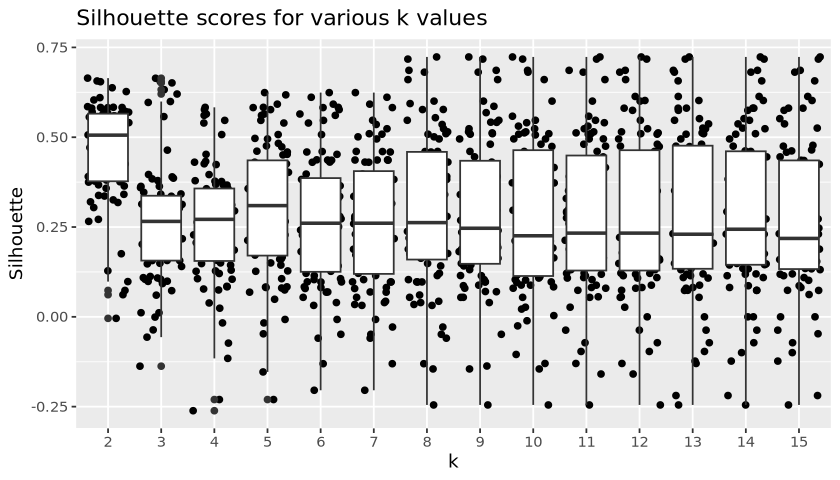

In [5]:
# Make the plot data
n_genes <- 125 # 30, 50, 100, 125, 150. Tried with many values and 125 showed best separation
top_genes <- matrixStats::rowVars(as.matrix(combined)) %>%
  sort(decreasing = T) %>%
  head(n_genes) %>%
  names()
plot.data <- combined[top_genes, ] %>% cor(method = "spearman")

# Identify optimal k
dist_mat <- dist(plot.data, method = "euclidean")
ward_dist <- hclust(dist_mat, method = "ward.D2")

max_k <- 15
sil_scores <- list()
for (k in 2:max_k) {
  # Cut the dendrogram to create k clusters
  cluster_cut <- cutree(ward_dist, k)

  # Calculate silhouette score
  score_vals <- silhouette(cluster_cut, dist_mat)[, "sil_width"]
  score_df <- data.frame(vals = score_vals)
  score_df$k <- k
  sil_scores[[k]] <- score_df
}
sil_scores <- bind_rows(sil_scores)

# Pick k with highest silhouette scores, plus fewest negative scores
options(repr.plot.width = 7, repr.plot.height = 4)
p1 <- ggplot(sil_scores, aes(factor(k), vals, group = factor(k))) +
  geom_jitter() +
  geom_boxplot() +
  ggtitle("Silhouette scores for various k values") +
  xlab("k") +
  ylab("Silhouette")
print(p1)  # Pick k=9 then combine groups after

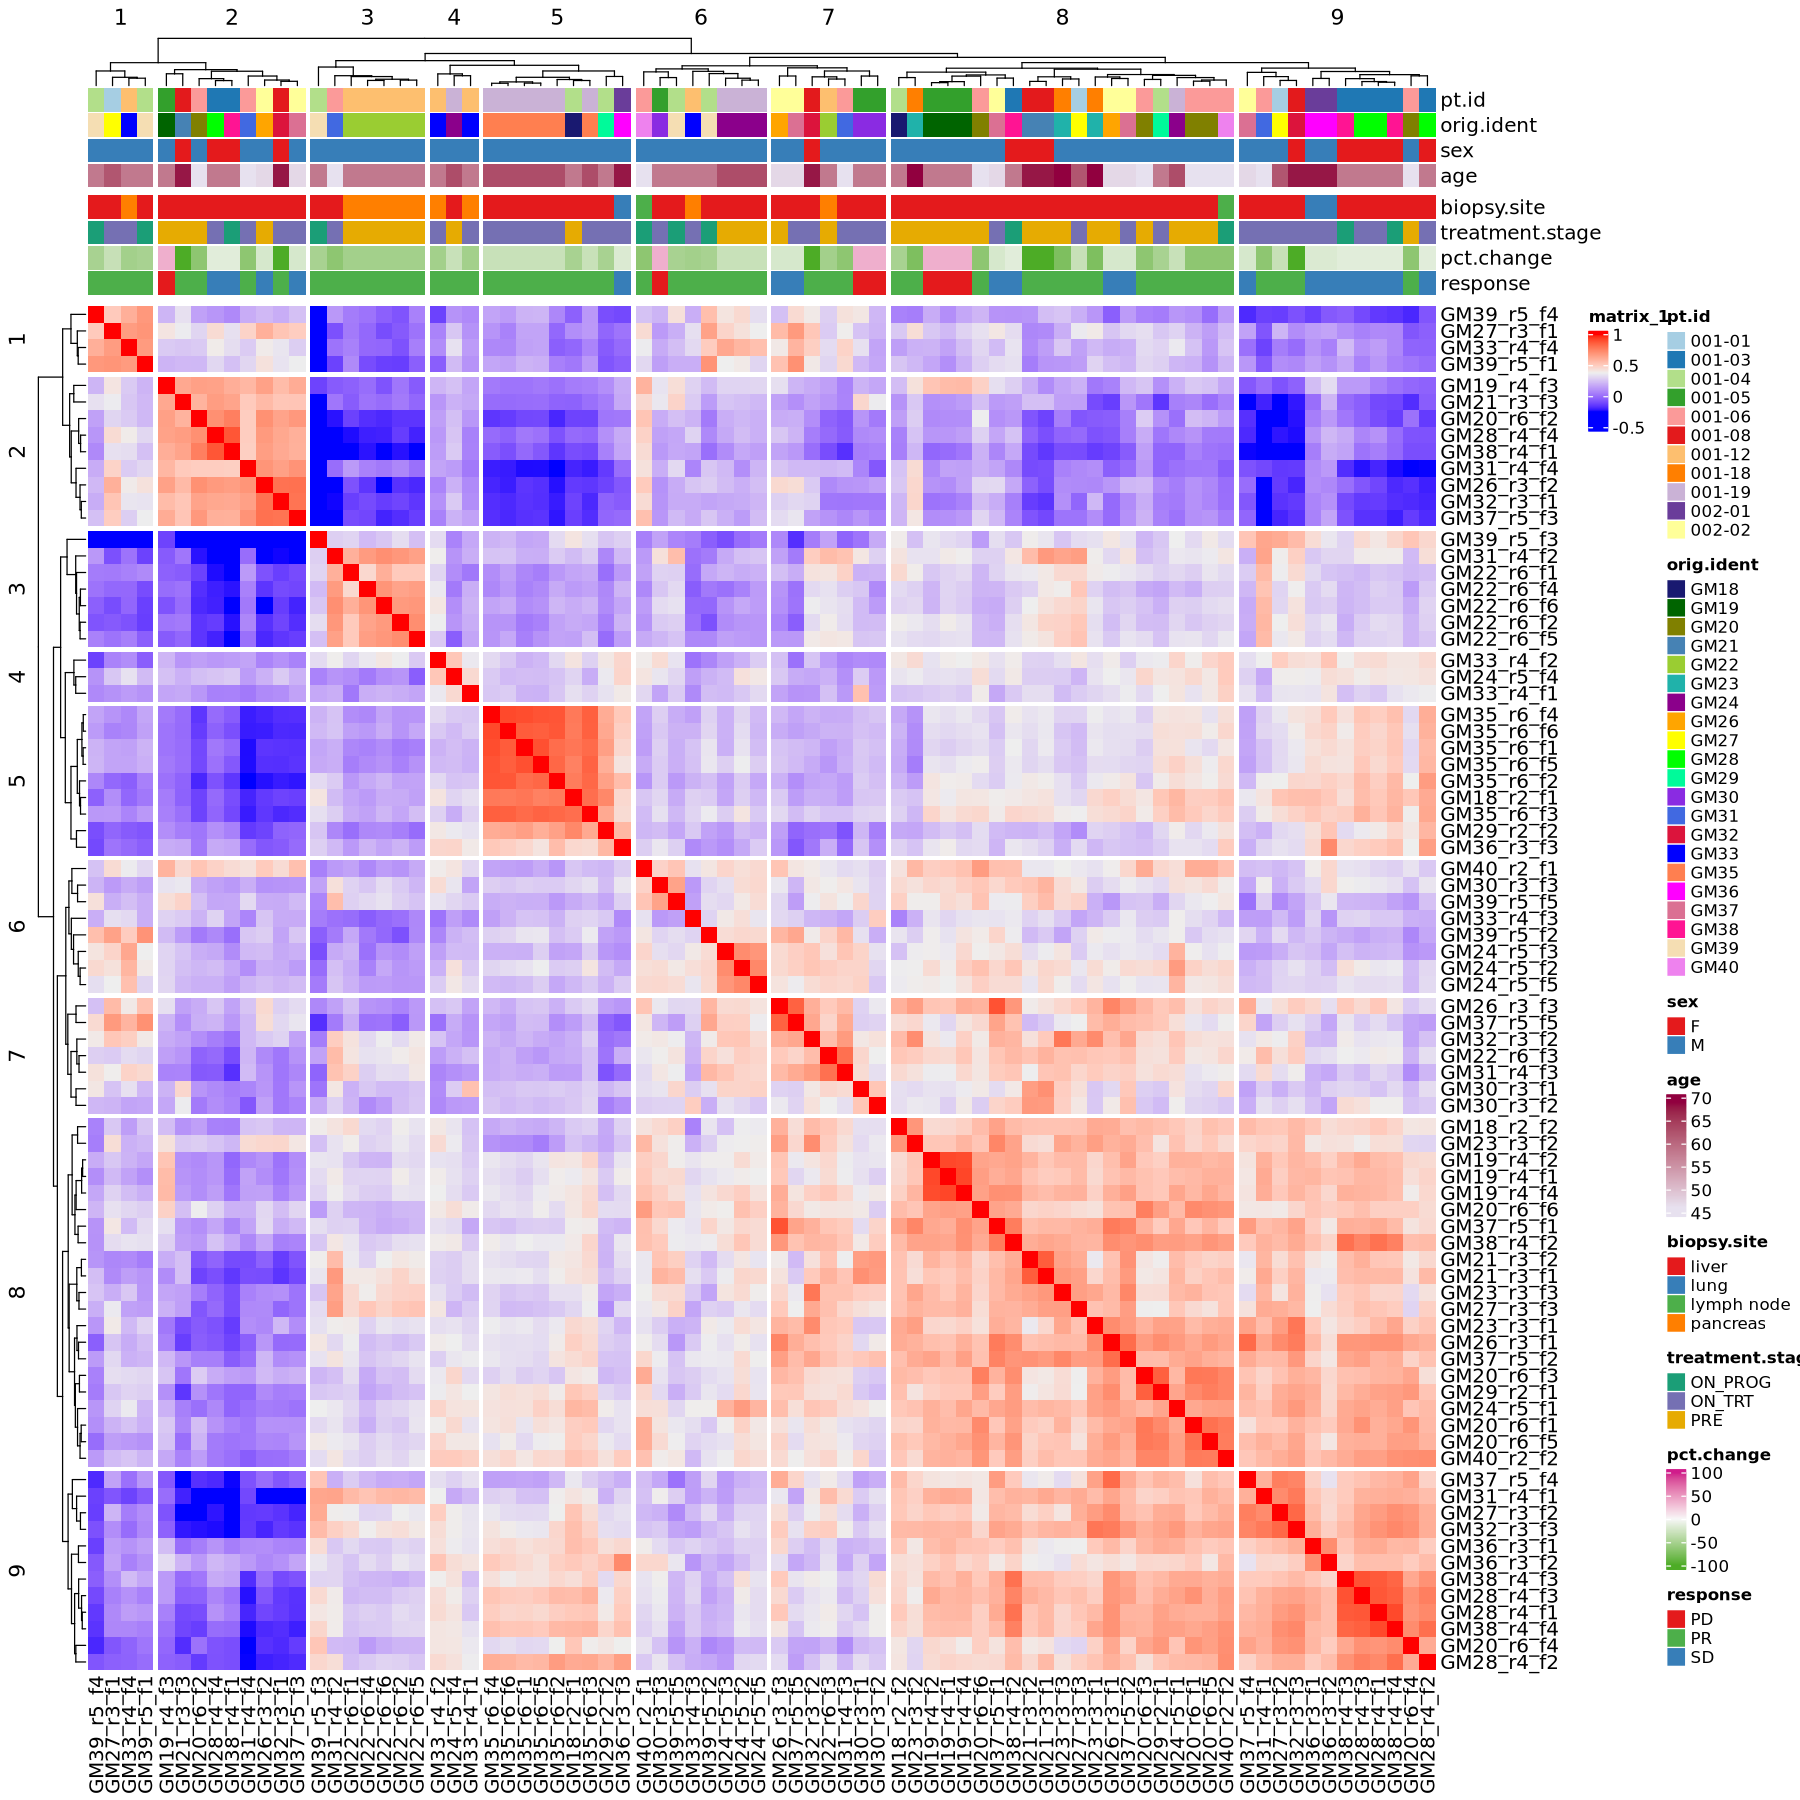

In [6]:
# Plot 

source("./helpers/color.R")
h <- 15
w <- 15
options(repr.plot.width = 15, repr.plot.height = 15)


k <- 9
p2 <- plot.data %>%
  Heatmap(
    top_annotation = make_column_ha(plot.data, metadata),
    row_split = k, column_split = k, border = F,
    row_gap = unit(1, "mm"),
    column_gap = unit(1, "mm"),
    row_dend_reorder = T,
    column_dend_reorder = T
  )
p2_d <- draw(p2)

factornames <- rownames(plot.data)
MPs <- lapply(
  row_order(p2_d),
  function(indices) factornames[indices]
)


# Now rename MPs by relative size
mp_to_factor <- list(
  "MP1" = MPs[[1]],
  "MP2" = MPs[[2]],
  "MP3" = MPs[[3]],
  "MP4" = MPs[[5]],
  "MP5" = c(MPs[[6]], MPs[[7]]),
  "MP6" = c(MPs[[8]], MPs[[9]])
)


factor_to_mp <- list()
for (factor in factornames) {
  factor_to_mp[[factor]] <- NA
  for (mp in names(mp_to_factor)) {
    if (factor %in% mp_to_factor[[mp]]) {
      factor_to_mp[[factor]] <- mp
    }
  }
  if (is.na(factor_to_mp[[factor]])) {
    factor_to_mp[[factor]] <- ""
  }
}
factor_to_mp <- factor(unlist(factor_to_mp),
  levels = c(
    "MP1", "MP2", "", "MP3",
    "MP4", "MP5", "MP6", "MP7"
  )
)





p3 <- Heatmap(plot.data,
  top_annotation = make_column_ha(plot.data, metadata),
  row_split = factor_to_mp, column_split = factor_to_mp,
  border = F,
  row_gap = unit(1, "mm"),
  column_gap = unit(1, "mm"),
  row_dend_reorder = T,
  column_dend_reorder = T,
  cluster_row_slices = FALSE,
  cluster_column_slices = FALSE,
  heatmap_legend_param = list(title = "correlation")
)



# pdf("/home/ubuntu/data/cxcr4-pdac/figures/FigS4E.pdf", width = w, height = h)
# draw(p3, merge_legend = T)
# dev.off()


In [7]:
#! In-text stats of MP2/6 association

factor_tbl <- factor_to_mp %>% 
    as.data.frame() %>% rename('MP_assign'='.') %>%
    rownames_to_column('factor') %>%
    separate(factor, into=c('samplename', 'factor'), sep='_', extra='merge') %>%
    merge(metadata, by.x='samplename', by.y='orig.ident', how='left') %>%
    mutate(response_binned = ifelse(response=='PR', 'PR', 'SD_PD')) %>%
    mutate(MP_binned = ifelse(MP_assign %in% c('MP2', 'MP6'), 'MP2_MP6', 'other'))
factor_tbl$response_binned <- factor(factor_tbl$response_binned, levels=c('SD_PD', 'PR'))
factor_tbl$MP_binned <- factor(factor_tbl$MP_binned, levels=c('MP2_MP6', 'other'))

fisher.test(table(factor_tbl$MP_binned, factor_tbl$response_binned))



	Fisher's Exact Test for Count Data

data:  table(factor_tbl$MP_binned, factor_tbl$response_binned)
p-value = 0.003756
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  1.527996 16.899153
sample estimates:
odds ratio 
  4.750302 


In [31]:
get_metagenes_from_metaprogram <- function(metaprogram_cols, thresh) {
  if (length(metaprogram_cols) == 1) {
    df <- combined %>% select(all_of(metaprogram_cols))
  } else {
    df <- combined[, metaprogram_cols]
  }

  out <- apply(df, 1, function(x) {
    y <- sum(x) / sqrt(length(x))
    # y <- sum(w*x)/sqrt(sum(w^2))
    return(y)
  }) %>% sort(decreasing = T)

  out <- data.frame(out) %>% rownames_to_column("gene")

  return(out %>% filter(out > thresh))
}

# For instance, get the gene contributions to MP5
# get_metagenes_from_metaprogram(MPs[[5]], 0.1) # %>% write.table('~/tmp/tmp.tsv', sep='\t', row.names=F, quote=F)


# Adapted from Dr. Tagore's script to correlate against Gavish 2023 metaprograms

# Load necessary libraries
library(ggplot2)

# Function to calculate Jaccard similarity between two sets
jaccard_similarity <- function(set1, set2) {
  intersection <- length(intersect(set1, set2))
  union_size <- length(union(set1, set2))
  jaccard_index <- intersection / union_size
  return(jaccard_index)
}

absolute_overlap <- function(set1, set2) {
  intersection <- length(intersect(set1, set2))
  return(intersection)
}

pct_set_1 <- function(set1, set2) {
  intersection <- length(intersect(set1, set2))
  return(intersection / length(set1))
}

# Function to create a correlation matrix from gene lists
create_correlation_matrix <- function(group1_genes, group2_genes, method = jaccard_similarity) {

  if (is.data.frame(group1_genes)) {
    length_func_group1 <- ncol
    names_func_group1 <- colnames
  } else if (is.list(group1_genes)) {
    length_func_group1 <- function(x) length(names(x))
    names_func_group1 <- names
  }
  if (is.data.frame(group2_genes)) {
    length_func_group2 <- ncol
    names_func_group2 <- colnames
  } else if (is.list(group2_genes)) {
    length_func_group2 <- function(x) length(names(x))
    names_func_group2 <- names
  }

  
  num_MPs_group1 <- length_func_group1(group1_genes)
  num_MPs_group2 <- length_func_group2(group2_genes)
  # Initialize matrix to store correlation coefficients
  correlation_matrix <- matrix(0, nrow = num_MPs_group1, ncol = num_MPs_group2)
  # Compute Jaccard similarity for each pair of gene sets
  for (i in 1:num_MPs_group1) {
    for (j in 1:num_MPs_group2) {
      correlation_matrix[i, j] <- method(unique(group1_genes[[i]]), unique(group2_genes[[j]]))
    }
  }
  rownames(correlation_matrix) <- names_func_group1(group1_genes)
  colnames(correlation_matrix) <- names_func_group2(group2_genes)
  return(correlation_matrix)
}



################################################################################
# Checkerboard plot
top_n <- 20
w <- 4
h <- 12
options(repr.plot.width = w, repr.plot.height = h)

gene_contribs <- lapply(seq_along(names(mp_to_factor)), function(mp) {
  df <- get_metagenes_from_metaprogram(mp_to_factor[[mp]], 0)
  df$MP <- paste0("MP", mp)
  df
}) %>% bind_rows()
gene_contrib_mat <- gene_contribs %>%
  pivot_wider(id_cols = gene, names_from = MP, values_from = out) %>%
  column_to_rownames("gene")
top_genes <- gene_contribs %>%
  group_by(MP) %>%
  slice_max(order_by = out, n = top_n) %>%
  .$gene %>%
  unique()

top_genes <- top_genes[!(top_genes %in% c("NEAT1", "MALAT1", "FP671120.4", "FP236383.3"))]



#! Table used to generate S6B, S6C
gene_contribs %>% write.table("/home/ubuntu/data/cxcr4-pdac/figures/MP_gene_contribs.tsv", sep = "\t", row.names = F)

p4 <- gene_contrib_mat[top_genes, ] %>% # symlog() %>%
  Heatmap(
    cluster_columns = F, cluster_rows = F,
    row_names_side = "right", column_names_side = "bottom",
    col = function(x) {
      min_cut <- 50
      ifelse(x < min_cut,
        "white",
        circlize::colorRamp2(
          c(min_cut, max(as.matrix(.), na.rm = T)),
          c("white", "black")
        )(x)
      )
    },
    heatmap_legend_param = list(title = "weight", legend_direction = "horizontal"),
    border_gp = gpar(col = "black", lwd = 2)
  )
# draw(p4)



# Example gene lists for two groups
# https://www.gsea-msigdb.org/gsea/msigdb/cards/HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION.html
hallmark_emt <- c("ABI3BP","ACTA2","ADAM12","ANPEP","APLP1","AREG","BASP1","BDNF","BGN","BMP1","CADM1","CALD1","CALU","CAP2","CAPG","CCN1","CCN2","CD44","CD59","CDH11","CDH2","CDH6","COL11A1","COL12A1","COL16A1","COL1A1","COL1A2","COL3A1","COL4A1","COL4A2","COL5A1","COL5A2","COL5A3","COL6A2","COL6A3","COL7A1","COL8A2","COLGALT1","COMP","COPA","CRLF1","CTHRC1","CXCL1","CXCL12","CXCL6","CXCL8","DAB2","DCN","DKK1","DPYSL3","DST","ECM1","ECM2","EDIL3","EFEMP2","ELN","EMP3","ENO2","FAP","FAS","FBLN1","FBLN2","FBLN5","FBN1","FBN2","FERMT2","FGF2","FLNA","FMOD","FN1","FOXC2","FSTL1","FSTL3","FUCA1","FZD8","GADD45A","GADD45B","GAS1","GEM","GJA1","GLIPR1","GPC1","GPX7","GREM1","HTRA1","ID2","IGFBP2","IGFBP3","IGFBP4","IL15","IL32","IL6","INHBA","ITGA2","ITGA5","ITGAV","ITGB1","ITGB3","ITGB5","JUN","LAMA1","LAMA2","LAMA3","LAMC1","LAMC2","LGALS1","LOX","LOXL1","LOXL2","LRP1","LRRC15","LUM","MAGEE1","MATN2","MATN3","MCM7","MEST","MFAP5","MGP","MMP1","MMP14","MMP2","MMP3","MSX1","MXRA5","MYL9","MYLK","NID2","NNMT","NOTCH2","NT5E","NTM","OXTR","P3H1","PCOLCE","PCOLCE2","PDGFRB","PDLIM4","PFN2","PLAUR","PLOD1","PLOD2","PLOD3","PMEPA1","PMP22","POSTN","PPIB","PRRX1","PRSS2","PTHLH","PTX3","PVR","QSOX1","RGS4","RHOB","SAT1","SCG2","SDC1","SDC4","SERPINE1","SERPINE2","SERPINH1","SFRP1","SFRP4","SGCB","SGCD","SGCG","SLC6A8","SLIT2","SLIT3","SNAI2","SNTB1","SPARC","SPOCK1","SPP1","TAGLN","TFPI2","TGFB1","TGFBI","TGFBR3","TGM2","THBS1","THBS2","THY1","TIMP1","TIMP3","TNC","TNFAIP3","TNFRSF11B","TNFRSF12A","TPM1","TPM2","TPM4","VCAM1","VCAN","VEGFA","VEGFC","VIM","WIPF1","WNT5A")
group1_genes <- read.csv("/home/ubuntu/data/cxcr4-pdac/signatures/Gavish_Metaprograms.csv") %>%
  column_to_rownames("SL") %>%
  as.list()
names(group1_genes) <- paste0('Gavish', names(group1_genes))
group1_genes[['MSIGDB_HALLMARK_EMT']] <- hallmark_emt

group2_genes <- gene_contribs %>%
  group_by(MP) %>%
  slice_max(out, n = 200) %>%
  mutate(row = row_number()) %>%
  select(-out) %>%
  ungroup() %>%
  pivot_wider(names_from = "MP", values_from = "gene") %>%
  column_to_rownames("row")

# Calculate correlation matrix
cor_mat <- create_correlation_matrix(group1_genes, group2_genes, absolute_overlap)
min_cut <- 4  # Highlight overlaps >=4
max_val <- max(cor_mat)

options(repr.plot.width = 5, repr.plot.height = 7)

p5 <- ComplexHeatmap::Heatmap(cor_mat,
  cluster_rows = F,
  cluster_columns = F,
  name = "Gene overlap between MP and published gene set",
  heatmap_legend_param = list(
    legend_direction = "horizontal",
    legend_width = unit(5, "cm")
  ),
  col = function(x) {
    ifelse(x <= min_cut,
      "white",
      circlize::colorRamp2(
        c(min_cut, max_val),
        c("#e5f5e0", "#006d2c")
      )(x)
    )
  },
  border_gp = gpar(col = "black", lwd = 2)
) # %>%
# draw(heatmap_legend_side = "top")



#! Figure S6A, S6B, S6C
options(repr.plot.width = 35, repr.plot.height = 20)
pdf(file = "/home/ubuntu/data/cxcr4-pdac/figures/FigS6ABC.pdf", width = 35, height = 20)
plot_list <- list(p3, p4, p5)
patchwork::wrap_plots(
  lapply(
    seq_along(plot_list),
    function(p) {
      position <- ifelse(p == 1, "right", "bottom")
      draw(plot_list[[p]], merge_legend = T, heatmap_legend_side = position) %>%
        grid.grabExpr()
    }
  ),
  ncol = 3,
  widths = c(0.7, 0.15, 0.15)
)
dev.off()


Warning message:
“The input is a data frame-like object, convert it to a matrix.”


agg_record_839063401 
                   2

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


 [1] "FN1"       "TIMP1"     "VIM"       "COL6A1"    "LAMC2"     "LAMB3"    
 [7] "FLNA"      "PMEPA1"    "KRT7"      "ITGB1"     "ITGA3"     "TGM2"     
[13] "ITGA6"     "ANXA2"     "KRT19"     "S100A6"    "TM4SF1"    "S100A10"  
[19] "LGALS3"    "S100A16"   "TAGLN2"    "LMNA"      "CRIP1"     "EZR"      
[25] "KRT18"     "S100A11"   "S100A4"    "HSPB1"     "KRT8"      "TMSB4X"   
[31] "CLIC1"     "IFI27"     "MDK"       "CLDN4"     "RAB11FIP1" "DST"      
[37] "TXNIP"     "FTH1"      "CD74"     
 [1] "CD59"   "DST"    "FLNA"   "FN1"    "IGFBP3" "ITGB1"  "LAMC2"  "PMEPA1"
 [9] "PPIB"   "QSOX1"  "SDC1"   "SDC4"   "TGM2"   "TIMP1"  "TPM4"   "VIM"   
FN1
TIMP1
VIM
LAMC2
FLNA
PMEPA1
ITGB1
TGM2
DST


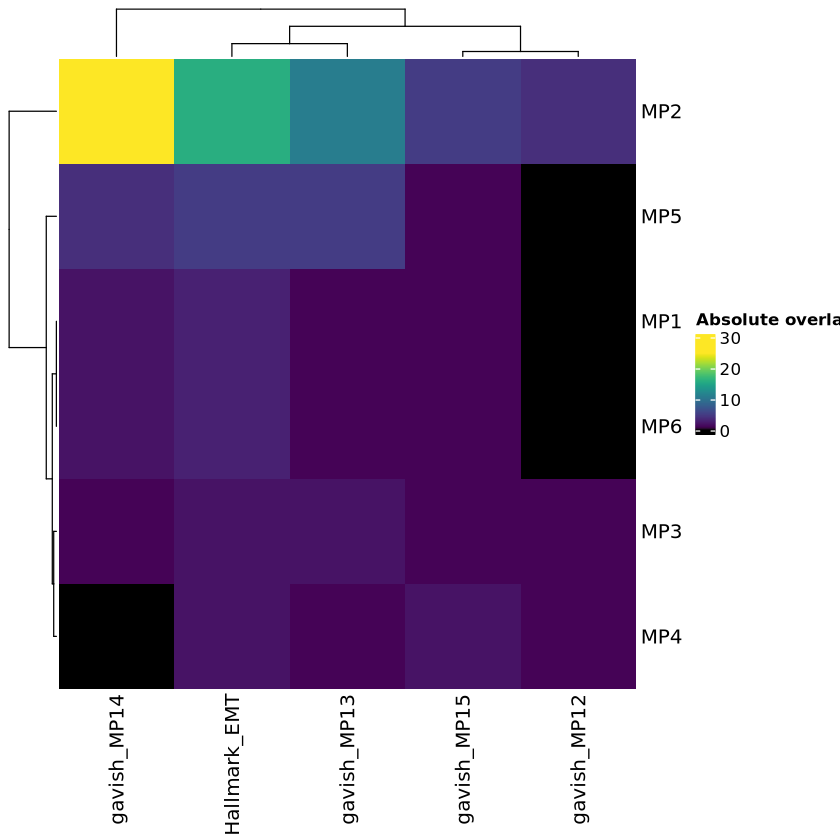

In [11]:
# This has been incorporated into #! S6C but here's a more standalone version
# that focuses just on EMT programs


# https://www.gsea-msigdb.org/gsea/msigdb/cards/HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION.html
hallmark_emt <- c("ABI3BP","ACTA2","ADAM12","ANPEP","APLP1","AREG","BASP1","BDNF","BGN","BMP1","CADM1","CALD1","CALU","CAP2","CAPG","CCN1","CCN2","CD44","CD59","CDH11","CDH2","CDH6","COL11A1","COL12A1","COL16A1","COL1A1","COL1A2","COL3A1","COL4A1","COL4A2","COL5A1","COL5A2","COL5A3","COL6A2","COL6A3","COL7A1","COL8A2","COLGALT1","COMP","COPA","CRLF1","CTHRC1","CXCL1","CXCL12","CXCL6","CXCL8","DAB2","DCN","DKK1","DPYSL3","DST","ECM1","ECM2","EDIL3","EFEMP2","ELN","EMP3","ENO2","FAP","FAS","FBLN1","FBLN2","FBLN5","FBN1","FBN2","FERMT2","FGF2","FLNA","FMOD","FN1","FOXC2","FSTL1","FSTL3","FUCA1","FZD8","GADD45A","GADD45B","GAS1","GEM","GJA1","GLIPR1","GPC1","GPX7","GREM1","HTRA1","ID2","IGFBP2","IGFBP3","IGFBP4","IL15","IL32","IL6","INHBA","ITGA2","ITGA5","ITGAV","ITGB1","ITGB3","ITGB5","JUN","LAMA1","LAMA2","LAMA3","LAMC1","LAMC2","LGALS1","LOX","LOXL1","LOXL2","LRP1","LRRC15","LUM","MAGEE1","MATN2","MATN3","MCM7","MEST","MFAP5","MGP","MMP1","MMP14","MMP2","MMP3","MSX1","MXRA5","MYL9","MYLK","NID2","NNMT","NOTCH2","NT5E","NTM","OXTR","P3H1","PCOLCE","PCOLCE2","PDGFRB","PDLIM4","PFN2","PLAUR","PLOD1","PLOD2","PLOD3","PMEPA1","PMP22","POSTN","PPIB","PRRX1","PRSS2","PTHLH","PTX3","PVR","QSOX1","RGS4","RHOB","SAT1","SCG2","SDC1","SDC4","SERPINE1","SERPINE2","SERPINH1","SFRP1","SFRP4","SGCB","SGCD","SGCG","SLC6A8","SLIT2","SLIT3","SNAI2","SNTB1","SPARC","SPOCK1","SPP1","TAGLN","TFPI2","TGFB1","TGFBI","TGFBR3","TGM2","THBS1","THBS2","THY1","TIMP1","TIMP3","TNC","TNFAIP3","TNFRSF11B","TNFRSF12A","TPM1","TPM2","TPM4","VCAM1","VCAN","VEGFA","VEGFC","VIM","WIPF1","WNT5A")
pathways <- list('Hallmark_EMT' = hallmark_emt,
                 'gavish_MP12' = group1_genes[['MP12.EMT.I']],
                 'gavish_MP13' = group1_genes[['MP13.EMT.II']],
                 'gavish_MP14' = group1_genes[['MP14.EMT.III']],
                 'gavish_MP15' = group1_genes[['MP15.EMT.IV']])


options(repr.plot.width=7, repr.plot.height=7)
lapply(pathways, function(genelist) sapply(group2_genes, function(mp_genelist) length(intersect(genelist, mp_genelist)))) %>%
 as.data.frame() %>% 
 ComplexHeatmap::Heatmap(col = c('black', viridis::viridis(29, option = "viridis")),
                        name = "Absolute overlap")


mp2_intersect_genes <- lapply(group1_genes, function(genelist) genelist[genelist %in% group2_genes[['MP2']]])

all_gavish_mp2_genes <- c(mp2_intersect_genes[['MP12.EMT.I']], 
    mp2_intersect_genes[['MP13.EMT.II']],
    mp2_intersect_genes[['MP14.EMT.III']],
    mp2_intersect_genes[['MP15.EMT.IV']]) %>% unique()

all_msig_mp2_genes <- hallmark_emt[hallmark_emt %in% group2_genes[['MP2']]]

print(all_gavish_mp2_genes) # Overlap of MP2 with gavish
print(all_msig_mp2_genes) # Overlap of MP2 with MSigDb
cat(intersect(all_gavish_mp2_genes, all_msig_mp2_genes), sep='\n')

In [ ]:
# For pasting into TCGA analysis
gene_contribs %>% filter(MP=='MP2') %>%
filter(!(gene %in% c('NEAT1', 'MALAT1', 'FP671120.4', 'FP236383.3'))) %>%
head(50) %>% 
.$gene %>% cat(sep='\n')

In [53]:
# Metaprogram sample breakdowns

res <- list()
for (f in names(factor_to_mp)) {
    oi <- get_col_meta(f, "orig.ident", metadata)
    mp <- factor_to_mp[[f]]
    ts <- get_col_meta(f, "treatment.stage", metadata)
    tr <- get_col_meta(f, "response", metadata)
    res[[f]] <- data.frame(factor = f, orig.ident = oi, metaprogram = mp, treatment.stage = ts, response = tr)
}

res <- bind_rows(res) %>% filter(metaprogram != "")

w <- 6
h <- 6
options(repr.plot.width = w, repr.plot.height = h)
p5 <- ggplot(
    res %>% count(metaprogram, orig.ident),
    aes(metaprogram, n, fill = orig.ident)
) +
    geom_bar(stat = "identity", color = "black") +
    scale_fill_manual(values = make_col_colors(metadata)[["orig.ident"]]) +
    theme_classic() +
    theme(legend.position = "bottom") +
    xlab("Metaprogram") +
    ylab("Count") +
    theme(
        axis.text = element_text(size = 16),
        axis.title = element_text(size = 16)
    ) +
    guides(fill = guide_legend(nrow = 4, byrow = T, title.position = "top"))




w <- 5
h <- 4
options(repr.plot.width = w, repr.plot.height = h)
p6 <- ggplot(
    res %>% count(metaprogram, treatment.stage),
    aes(metaprogram, n, fill = treatment.stage)
) +
    geom_bar(stat = "identity", color = "black") +
    scale_fill_manual(
        values = make_col_colors(metadata)[["treatment.stage"]],
        breaks = c("PRE", "ON_TRT", "ON_PROG")
    ) +
    theme_classic() +
    theme(legend.position = "bottom") +
    xlab("Metaprogram") +
    ylab("Count") +
    theme(
        axis.text = element_text(size = 16),
        axis.title = element_text(size = 16)
    ) +
    guides(fill = guide_legend(nrow = 1, byrow = T, title.position = "left"))

w <- 5
h <- 4
options(repr.plot.width = w, repr.plot.height = h)
p7 <- ggplot(
    res %>% count(metaprogram, response),
    aes(metaprogram, n, fill = response)
) +
    geom_bar(stat = "identity", color = "black") +
    scale_fill_manual(
        values = make_col_colors(metadata)[["response"]],
        breaks = c("PD", "SD", "PR")
    ) +
    theme_classic() +
    theme(legend.position = "bottom") +
    xlab("Metaprogram") +
    ylab("Count") +
    theme(
        axis.text = element_text(size = 16),
        axis.title = element_text(size = 16)
    ) +
    guides(fill = guide_legend(nrow = 1, byrow = T, title.position = "left"))



### Som's various accessory scripts

In [32]:
barcodes_to_factors <- function(samplename, rank) {
    # Adapted from KINOMO downstream script sort.barcodes.R
    h_file <- file.path('/home/ubuntu/data/cxcr4-pdac/nmf',
                        samplename, 
                        paste0('rank_', rank),
                        paste0(samplename, '_rank_', rank, '_H.csv'))
    df1 <- read.csv(file=h_file) %>%
        column_to_rownames('X') %>%
        t()
    j1 <- max.col(df1, "first") # For each barcode, find factor it contributes most to

    df2 <- data.frame(matrix(ncol = 0, nrow = nrow(df1)))
    rownames(df2) <- rownames(df1)
    df2$Group <- paste0(samplename, '_r', rank, '_f', j1)

    return(df2)
}


# Correct for different barcodes in combined dataset
# GM34 is still represented in suffixes despite not being in malig compartment
suffixes <- 1:22
names(suffixes) <- c(paste0('GM', 18:24), paste0('GM', 26:40))

barcode_factor_groups <- lapply(names(optimal_ranks), function(samplename) {
  out <- barcodes_to_factors(samplename, optimal_ranks[[samplename]]) %>% 
    rownames_to_column('barcode')

  out$barcode <- gsub('\\..*$', '', out$barcode)
  out$barcode <- paste0(out$barcode, '-1_', suffixes[[samplename]])
  return(out %>% column_to_rownames('barcode'))
}) %>% bind_rows() 


malig <- malig %>% AddMetaData(barcode_factor_groups)
length(malig@meta.data[is.na(malig@meta.data$Group)]) == 0  # Verify it worked

[1] TRUE

### CIN scores within each MP

In [33]:
# Make sure you've already run the barcode_factor_groups and mp_to_factor blocks
source('./helpers/cin70.R')

genelist <- list('CIN70'=cin70_genes)
malig2 <- malig %>% 
          AddModuleScore(genelist, assay='RNA', name='CIN70') %>%
          UCell::AddModuleScore_UCell(genelist, assay='RNA', name='_UCell')

Warning message:
“The following features are not present in the object: H2AFZ , H2AZ1, H2AX , PDCD2L , not searching for symbol synonyms”
Warning message:
“The following genes were not found and will be
                        imputed to exp=0:
* H2AFZ ,H2AZ1,H2AX ,PDCD2L ”


treatment.stage,avg_cin70,median_cin70
<fct>,<dbl>,<dbl>
PRE,0.011886315,0.005852115
ON_TRT,0.007071875,0.004782348
ON_PROG,0.013506067,0.009712170



	Kruskal-Wallis rank sum test

data:  CIN70_UCell by treatment.stage
Kruskal-Wallis chi-squared = 25.208, df = 2, p-value = 3.358e-06


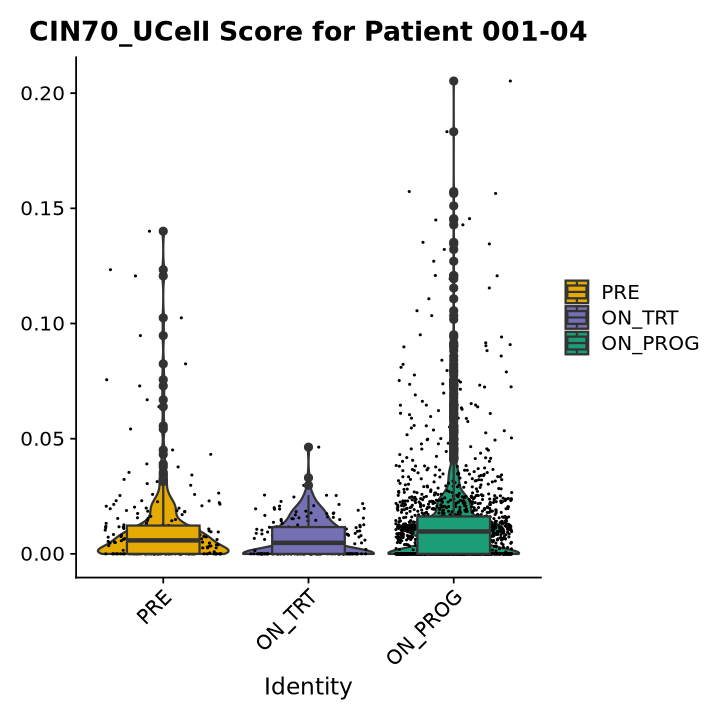

In [34]:
# Patient who had a PR before eventionally getting an on-progression biopsy
source("./helpers/color.R")

options(repr.plot.width=6, repr.plot.height=6)

malig2$treatment.stage <- factor(malig2$treatment.stage, levels = c("PRE", "ON_TRT", "ON_PROG"))
VlnPlot(subset(malig2, subset = pt.id == "001-04"), group.by = "treatment.stage", features = "CIN70_UCell") +
  geom_boxplot(width = 0.5) +
  scale_fill_manual(values = colors_treatment_stage) +
  ggtitle("CIN70_UCell Score for Patient 001-04")

malig2@meta.data %>%
  filter(pt.id == "001-04") %>%
  group_by(treatment.stage) %>%
  summarize(avg_cin70 = mean(CIN70_UCell), median_cin70 = median(CIN70_UCell))

kruskal.test(formula = CIN70_UCell ~ treatment.stage, 
            data = malig2@meta.data %>% filter(pt.id == "001-04"))


In [ ]:
w <- 9
h <- 5
options(repr.plot.width=w, repr.plot.height=h)
xtheme <- theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
VlnPlot(malig2, features='CIN701', group.by='Group', sort=T) + NoLegend() + xtheme
VlnPlot(malig2, features='CIN70_UCell', group.by='Group', sort=T) + NoLegend() + xtheme

In [ ]:
VlnPlot(malig2, features='CIN701', group.by='orig.ident', sort=T)

MP1       MP6       MP3       MP2       MP5       MP4        NA 
"#1B9E77" "#D95F02" "#7570B3" "#E7298A" "#66A61E" "#E6AB02" "#A6761D"

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).”


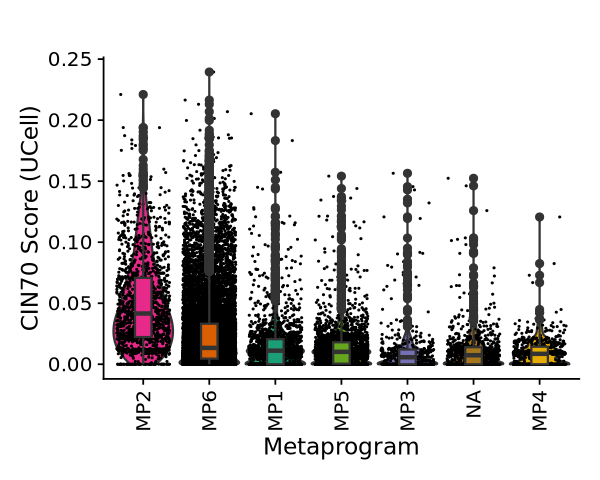

In [36]:
#! Figure 4D
# Exact stats are in next cell

barcodes <- rownames(malig@meta.data)
barcode_to_mp <- sapply(malig@meta.data$Group, function(x)  {
  mp_name <- factor_to_mp[[x]]
  if (mp_name != '') {
    return(as.character(mp_name))
  } else {
    return('NA')
  }
})
names(barcode_to_mp) <- barcodes
malig2$MP <- barcode_to_mp



xtheme <- theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
# VlnPlot(malig2, features='CIN701', group.by='MP', sort=T) + NoLegend() + xtheme + geom_boxplot(width=0.5) + coord_flip()


w <- 5
h <- 4

mp_color_scale <- RColorBrewer::brewer.pal(7, 'Dark2')
names(mp_color_scale) <- c('MP1', 'MP6', 'MP3', 'MP2', 'MP5', 'MP4', 'NA')

mp_color_scale

options(repr.plot.width=w, repr.plot.height=h)
cin70_plot <- VlnPlot(malig2, features='CIN70_UCell', group.by='MP', sort=T) + 
    NoLegend() + xtheme + geom_boxplot(width=0.25) + 
    xlab('Metaprogram') + ylab('CIN70 Score (UCell)') + ggtitle('') +
    annotate('text', x=5, y=0.25, label='p < 2.2e-16,\nKruskal-Wallis') +  # See cell below for exact value
    scale_fill_manual(values=mp_color_scale)
cin70_plot
ggsave(plot = cin70_plot, filename='/home/ubuntu/data/cxcr4-pdac/figures/cin70_plot.pdf', height=h, width=w)
ggsave(plot = cin70_plot, filename='/home/ubuntu/data/cxcr4-pdac/figures/Fig4D.pdf', height=h, width=w)

In [37]:
#! Figure 4D, more precise statistical significance
cin70_test <- kruskal.test(CIN70_UCell ~ MP, data = malig2@meta.data)
cin70_test


# q <- Rmpfr::mpfr(1841.6, prec = 200)  # This doesn't play cleanly with the pchisq function
# Instead use pchisq to compute the log p value then use Rmpfr to convert to decimal
pchisq(1841.6, df = 6, lower.tail = FALSE, log.p=T)/log(10)
base <- Rmpfr::mpfr(10, prec=100)
expn <- Rmpfr::mpfr(-394.270115013496, prec=100)
base^expn


	Kruskal-Wallis rank sum test

data:  CIN70_UCell by MP
Kruskal-Wallis chi-squared = 1841.3, df = 6, p-value < 2.2e-16


[1] -394.2701

1 'mpfr' number of precision  100   bits 
[1] 5.3688959395002747002199836871639e-395

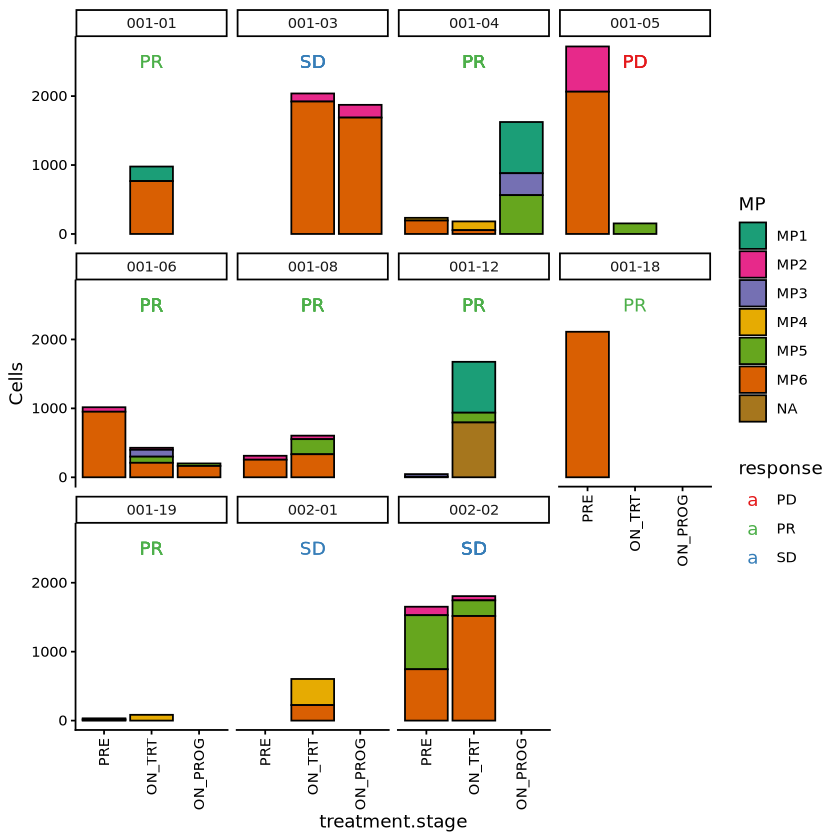

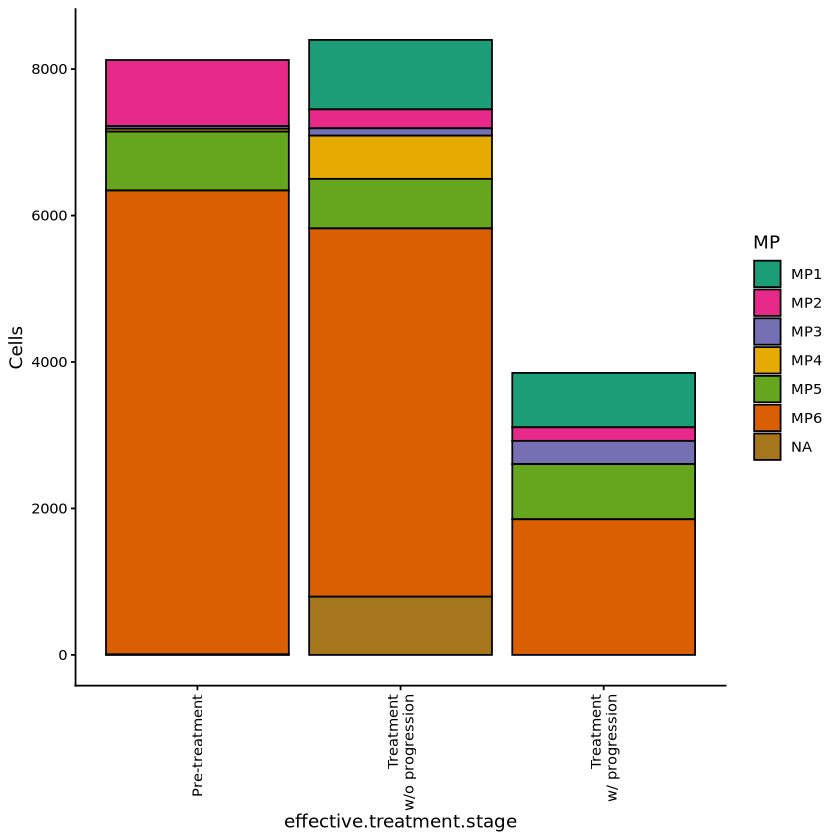

In [40]:
#! Figure S6F

w<- 7; h <- 7
options(repr.plot.width=w, repr.plot.height=h)
malig2$treatment.stage <- factor(malig2$treatment.stage, levels=c('PRE', 'ON_TRT', 'ON_PROG'))
cells_to_mp_by_patient <- malig2@meta.data %>%
{
    ggplot(., aes(x = treatment.stage, fill = MP)) +
    geom_bar(stat='count', color='black') +
    facet_wrap(~ pt.id) +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    geom_text(aes(x=2, y=2500, label=response, color=response),
              data = . %>% select(pt.id, MP, treatment.stage, response) %>% unique()) + 
    scale_color_manual(values=colors_treatment_response) +
    scale_fill_manual(values=mp_color_scale) + 
    ylab('Cells')
}
print(cells_to_mp_by_patient)
# ggsave(plot = cells_to_mp_by_patient, filename='/home/ubuntu/data/cxcr4-pdac/figures/new_numbering/FigS4J.pdf', height=h, width=w)


# malig2$is_secondary_resister <- malig2$pt.id %in% c('001-03','001-04','001-05', '001-06')

# w <- h; h <- 5
# options(repr.plot.width=w, repr.plot.height=h)
# cells_to_mp_by_resistance <- cell_diversity %>% {
#     facet_labels <- c(
#         'FALSE' = "Non-resisters",
#         'TRUE' = 'Secondary resisters'
#     )
#     ggplot(., aes(x = treatment.stage, fill = MP)) +
#     geom_bar(stat='count', color='black') +
#     facet_wrap(~ is_secondary_resister, labeller = labeller(.cols = facet_labels)) +
#     theme_classic() +
#     theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
#     scale_color_manual(values=colors_treatment_response) +
#     scale_fill_manual(values=mp_color_scale) + 
#     ylab('Cells')
# }
# print(cells_to_mp_by_resistance)
# ggsave(plot = cells_to_mp_by_resistance, filename='/home/ubuntu/data/cxcr4-pdac/figures/new_numbering/FigS4J2.pdf', height=h, width=w)


# "Effective" treatment stage treats on-trt sample for PD as progression biopsy
malig2@meta.data$effective.treatment.stage <- ifelse(malig2$treatment.stage=='PRE', 'Pre-treatment',
                                                        ifelse(malig2$treatment.stage=='ON_TRT', 'Treatment\nw/o progression',
                                                          ifelse(malig2$treatment.stage=='ON_PROG', 'Treatment\nw/ progression', NA)))
malig2@meta.data[(malig2@meta.data$response=='PD') & (malig2@meta.data$treatment.stage=='ON_TRT'), 'effective.treatment.stage'] <- 'Treatment\nw/ progression'


malig2$effective.treatment.stage <- factor(malig2$effective.treatment.stage, levels=c('Pre-treatment', 'Treatment\nw/o progression', 'Treatment\nw/ progression'))    


p2 <- ggplot(malig2@meta.data, aes(x=effective.treatment.stage, fill=MP)) +
    geom_bar(stat='count', color='black') +
    theme_classic() +
    theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1)) +
    scale_fill_manual(values=mp_color_scale) +
    ylab('Cells')

print(p2)
 ggsave(plot = p2, filename='/home/ubuntu/data/cxcr4-pdac/figures/FigS6F.pdf', height=h, width=w)





refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,-2*log(L),Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m0,3,218.4702,221.6037,-106.2351,212.4702,NA,NA,NA
m1,4,215.8911,220.0692,-103.9455,207.8911,4.579102,1,0.03236418


Linear mixed model fit by REML ['lmerMod']
Formula: fraction_2_6 ~ pre_vs_post + (1 | pt.id)
   Data: mp2_mp6_pct

REML criterion at convergence: 194.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4107 -0.2802  0.1440  0.6219  1.3253 

Random effects:
 Groups   Name        Variance Std.Dev.
 pt.id    (Intercept) 791.3    28.13   
 Residual             726.2    26.95   
Number of obs: 21, groups:  pt.id, 11

Fixed effects:
                Estimate Std. Error t value
(Intercept)        78.68      13.21   5.955
pre_vs_postPost   -31.96      13.00  -2.458

Correlation of Fixed Effects:
            (Intr)
pr_vs_pstPs -0.609

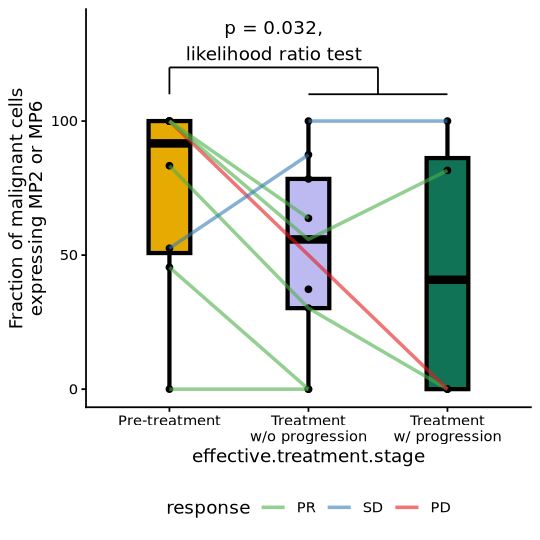

In [52]:
#! Fig S6G

fibroblast_numbers <- read.table('/home/ubuntu/tmp/fib_comp_crosstabs.tsv', sep='\t', header=1) %>%
  replace(is.na(.), 0) %>%
  .[,c(1,11:31)]  %>%
  pivot_longer(cols=2:22, names_to='orig.ident', values_to='cell_count') %>%
  pivot_wider(names_from='granular_annot', values_from='cell_count') %>% 
  column_to_rownames('orig.ident') %>%
  mutate(total_cells=rowSums(.)) %>%
  mutate(cxcl12_fraction=100*`Fibroblast::CXCL12+ fibr.`/total_cells) %>%
  rownames_to_column('orig.ident') %>%
  rename('cxcl12_count' = `Fibroblast::CXCL12+ fibr.`) %>%
  select(orig.ident, cxcl12_fraction, cxcl12_count)

malig2$response <- factor(malig2$response, levels=c('PR', 'SD' ,'PD'))
fullmd <- malig2@meta.data %>%
  rownames_to_column('bc') %>%
  merge(fibroblast_numbers, how='left', by='orig.ident') %>%
  column_to_rownames('bc') %>%
  select(pt.id, orig.ident, effective.treatment.stage, response, MP, cxcl12_count, cxcl12_fraction, CIN70_UCell, CIN701) 
  

mp2_mp6_pct <-  fullmd %>%
  group_by(pt.id, orig.ident, response, effective.treatment.stage) %>% 
  count(MP) %>%
  ungroup() %>%
  pivot_wider(names_from=MP, values_from=n) %>%
  rowwise() %>%
  mutate(total_cells = sum(MP1, MP2, MP3, MP4, MP5, MP6, `NA`, na.rm=TRUE)) %>%
  mutate(fraction_2_6 = 100* sum(MP2, MP6, na.rm=T) / total_cells) %>%
  mutate(fraction_4 = MP4/total_cells*100) %>%
  replace(is.na(.), 0) %>%
  mutate(pre_vs_post = ifelse(effective.treatment.stage=='Pre-treatment', 'Pre', 'Post'))
  
  
mp2_mp6_pct %>%
  {
    p <- ggplot(., aes(effective.treatment.stage, fraction_2_6)) +
      geom_boxplot(outlier.shape=NA, width=0.3, linewidth=1.2, color='black', aes(fill=effective.treatment.stage)) + 
      scale_fill_manual(values=colors_effective_treatment_stage) +
      geom_point() +
      geom_line(alpha=0.6, aes(group=pt.id, color=response), linewidth=1) +
      theme_classic() +
      scale_color_manual(values=colors_treatment_response) +
      guides(fill='none') + theme(legend.position='bottom') +
      ylab('Fraction of malignant cells\nexpressing MP2 or MP6') +
      # Manual significance bars
      annotate('segment', x = 1, xend = 2.5, y = 120, yend = 120) +
      annotate('segment', x = 1, xend = 1, y = 110, yend = 120) +
      annotate('segment', x = 2.5, xend = 2.5, y = 110, yend = 120) +
      annotate('segment', x = 2, xend = 3, y = 110, yend = 110) +
      annotate("text", x = 1.75, y = 130, label = "p = 0.032,\nlikelihood ratio test") +  # Test is below
      ylim(0, 135)


    h <- 4.5
    w <- 4.5
    options(repr.plot.width=w, repr.plot.height=h)
    print(p)
      ggsave(filename='/home/ubuntu/data/cxcr4-pdac/figures/FigS6G.pdf', height=h, width=w)

  }

mp2_mp6_pct$pre_vs_post <- factor(mp2_mp6_pct$pre_vs_post, levels=c('Pre', 'Post'))
m1 <- lme4::lmer(fraction_2_6 ~ pre_vs_post + (1|pt.id), data=mp2_mp6_pct)
m0 <- lme4::lmer(fraction_2_6 ~ (1|pt.id), data=mp2_mp6_pct)

anova(m0, m1)
summary(m1)

### MP Signature scores

#! Fig S6H

In [55]:
genelist <- list()
for (mp in 1:6) {
    for (genelevel in c(25, 50, 70, 100, 200)) {
        genelist[[paste0('MP', mp, '_', genelevel)]] <- group2_genes[[paste0('MP', mp)]] %>% head(genelevel)
    }
}

malig2 <- malig2 %>%
    UCell::AddModuleScore_UCell(genelist, assay='RNA', name='_UCell')


Warning message:
“Scaling data with a low number of groups may produce misleading results”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Warning message:
“Scaling data with a low number of groups may produce misleading results”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Warning message:
“Scaling data with a low number of groups may produce misleading results”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


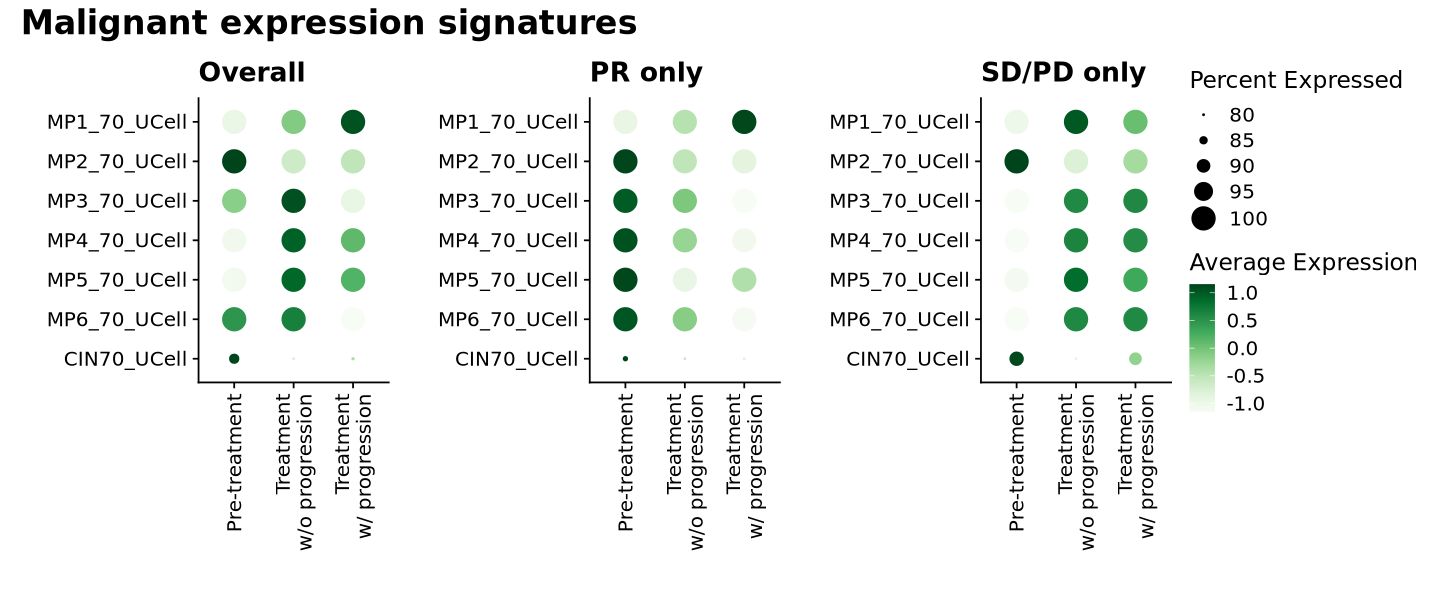

In [72]:
#! Fig S6H

group_var <- 'effective.treatment.stage'
split_var <- 'response'
ngenes <- 70

colors_plot <- list('response' = colors_treatment_response, 
                'treatment.stage' = colors_treatment_stage, 
                'effective.treatment.stage' = colors_effective_treatment_stage)[[group_var]]


Idents(malig2) <- 'effective.treatment.stage'
scale.min <- 80
scale.max <- 100
p1 <- DotPlot(malig2, 
      features=c(paste0('MP', 1:6, '_', ngenes, '_UCell'), 'CIN70_UCell') %>% rev(), 
      dot.min=0, 
      scale.min=scale.min, scale.max=scale.max) + 
      coord_flip() + 
      theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
      scale_color_gradientn(colors = dotplot_colors) +
      ggtitle('Overall') + NoLegend() + xlab('') + ylab('')


p2 <- DotPlot(malig2 %>% subset(subset=response=='PR'), 
      features=c(paste0('MP', 1:6, '_', ngenes, '_UCell'), 'CIN70_UCell') %>% rev(), 
      dot.min=0, 
      scale.min=scale.min, scale.max=scale.max) + 
      coord_flip() + 
      theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
      scale_color_gradientn(colors = dotplot_colors) +
      ggtitle('PR only') + NoLegend() + xlab('') + ylab('')

p3 <- DotPlot(malig2 %>% subset(subset=response!='PR'), 
      features=c(paste0('MP', 1:6, '_', ngenes, '_UCell'), 'CIN70_UCell') %>% rev(), 
      dot.min=0, 
      scale.min=scale.min, scale.max=scale.max) + 
      coord_flip() + 
      theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
      scale_color_gradientn(colors = dotplot_colors) +
      ggtitle('SD/PD only') + xlab('') + ylab('')


h <- 5
w <- 12
options(repr.plot.height=h, repr.plot.width=w)
(p1 | p2 | p3) + 
  plot_layout(ncol = 3, guides = "collect") &
  theme(legend.position = "right") & 
  plot_annotation(title='Malignant expression signatures', theme = theme(plot.title = element_text(size = 20, face='bold')))
ggsave('/home/ubuntu/data/cxcr4-pdac/figures/FigS6H.pdf', width=w, height=h)

### MP gene list ontology

In [ ]:
# `numbat` kernel
library(clusterProfiler)
library(org.Hs.eg.db)
library(patchwork)
library(Seurat)
library(tidyverse)

plot_go <- function(weight_df, mp, top_n=20, n_category=10) {
    genes <- weight_df %>% filter(MP == mp) %>% 
            arrange(-out) %>% head(top_n) %>% .$gene %>% 
             bitr(fromType = "SYMBOL",
                    toType = c("ENTREZID"),
                    OrgDb = org.Hs.eg.db)

    ego1 <- enrichGO(gene         = genes$ENTREZID,
                    OrgDb         = org.Hs.eg.db,
                    ont           = "BP", # ALL, MF, BP, CC
                    pAdjustMethod = "BH",
                    pvalueCutoff  = 0.01,
                    qvalueCutoff  = 0.05,
                    readable      = TRUE)

    p1 <- dotplot(ego1, showCategory=n_category) + 
            ggtitle(paste0(mp, ' top ', top_n, ' gene ontology'))
    out <- list(go = ego1,  plot=p1)
    return(out)
}

weight_df <- read.table('/home/ubuntu/data/cxcr4-pdac/figures/MP_gene_contribs.tsv', sep='\t', header=T)

plots <- list()
for (i in paste0('MP', 1:6)) {
  plots[[i]] <- plot_go(weight_df, i, 150, 10)$plot
}

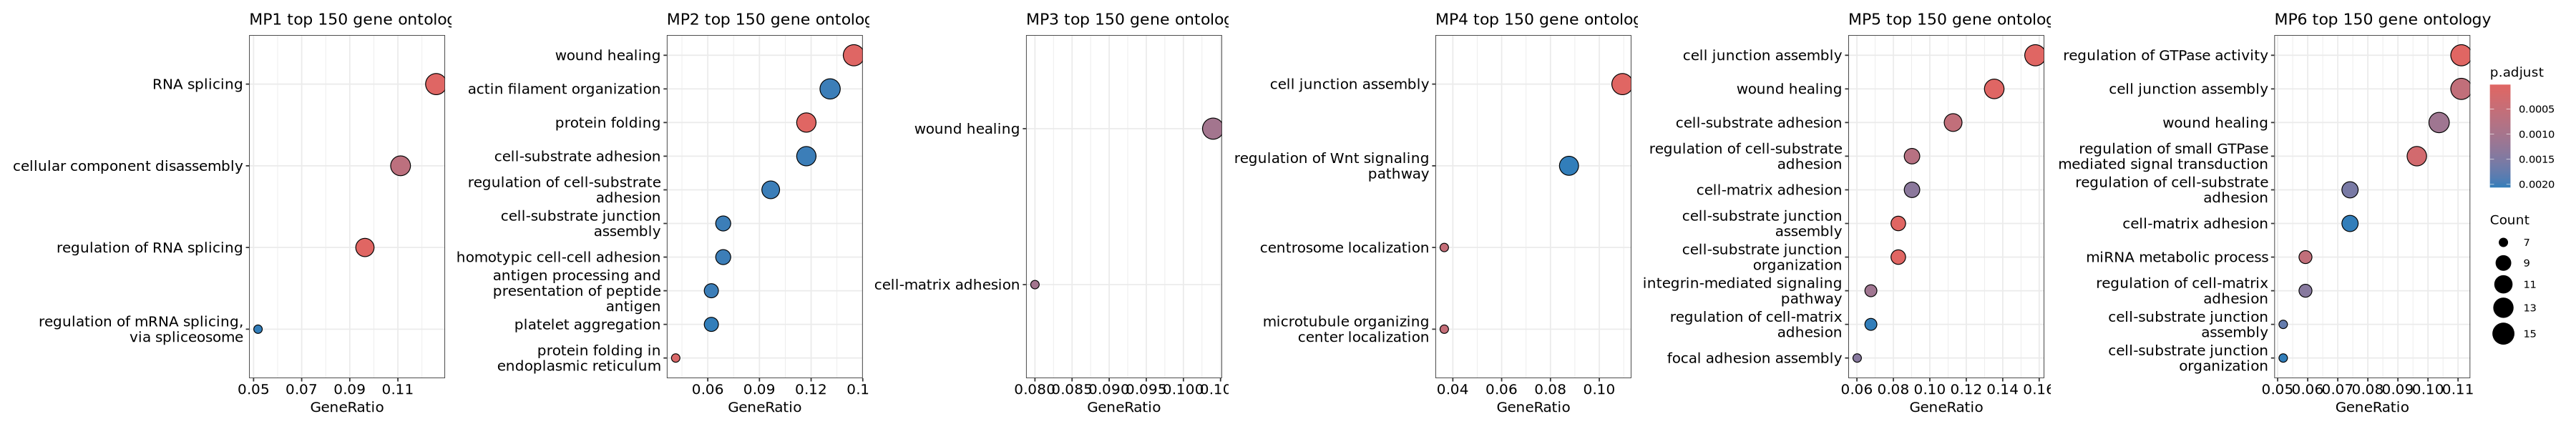

In [ ]:
options(repr.plot.width=30, repr.plot.height=5)
(plots[['MP1']] + NoLegend()) | 
(plots[['MP2']] + NoLegend()) | 
(plots[['MP3']] + NoLegend()) | 
(plots[['MP4']] + NoLegend()) | 
(plots[['MP5']] + NoLegend()) | 
(plots[['MP6']]) 

# Quantifying Diversity

Method adapted from Ma, L. et al. Tumor Cell Biodiversity Drives Microenvironmental Reprogramming in Liver Cancer. Cancer Cell 36, 418-430.e6 (2019).

In [74]:
pca_mat <- Embeddings(malig, reduction = "pca")[, 1:50]

diversity <- list()
cells_ignores <- list()
n_cells <- list()

for (sample in unique(malig$orig.ident)) {
  sample_cells <- malig@meta.data[malig@meta.data$orig.ident==sample,]  # Getting buggy behavior with dplyr `filter`
  sample_barcodes <- rownames(sample_cells)
  n_cells[[sample]] <- length(sample_barcodes)
  sample_pcs <- pca_mat[sample_barcodes, ]

  averages <- apply(sample_pcs, 2, mean)
  stds <- apply(sample_pcs, 2, sd)

  num_removed <- 0
  euc_dists <- c()

  for (row in 1:nrow(sample_pcs)) {  # Barcode by barcode within the sample
    sum_of_diff <- 0
    include <- T

    for (i in 1:50) {  # PC by PC within each cell
      pc <- paste0('PC_', i)

      if (include) {
        diff <- sample_pcs[row, pc] - averages[[pc]]
        if (abs(diff) < (4 * stds[[pc]])) {
          sum_of_diff <- sum_of_diff + (diff**2)
        } else {
          num_removed <- num_removed + 1
          include <- F  # If a cell has ANY outlier PC, we filter it out  
        }
      }
    }
    
    # Update euclidean distance calculation if cell isn't discarded
    if (include) {
      euc_dist_of_cell_to_centroid <- sqrt(sum_of_diff)
      euc_dists <- c(euc_dists, euc_dist_of_cell_to_centroid)
    }
  }
  
  diversity[[sample]] <- euc_dists  # Average distance
  cells_ignores[[sample]] <- num_removed
}

In [ ]:
source('./helpers/color.R')

w <- 4
h <- 4
options(repr.plot.width=w, repr.plot.height=h)

# With corrected denominator
div_df <- diversity %>%
         lapply(mean) %>%
         as.data.frame() %>% 
          t() %>% as.data.frame() %>% 
          rownames_to_column('orig.ident') %>% 
          rename('diversity'='V1')

# With uncorrected denominator
# div_df <- lapply(names(diversity), function(x) sum(diversity[[x]])/n_cells[[x]])
# names(div_df) <- names(diversity)
# div_df <- as.data.frame(div_df) %>% 
#           t() %>% as.data.frame() %>% 
#           rownames_to_column('orig.ident') %>% 
#           rename('diversity'='V1')


diversity_scoring <- merge(metadata, div_df, how='left', by='orig.ident')
diversity_scoring$treatment.stage <- factor(diversity_scoring$treatment.stage, levels=c('PRE', 'ON_TRT', 'ON_PROG'))
diversity_scoring$response <- factor(diversity_scoring$response, levels=c('PR', 'SD', 'PD'))

# "Effective" treatment stage treats on-trt sample for PD as progression biopsy
diversity_scoring$effective.treatment.stage <- ifelse(diversity_scoring$treatment.stage=='PRE', 'Pre-treatment',
                                                        ifelse(diversity_scoring$treatment.stage=='ON_TRT', 'Treatment\nw/o progression',
                                                          ifelse(diversity_scoring$treatment.stage=='ON_PROG', 'Treatment\nw/ progression', NA)))
diversity_scoring[(diversity_scoring$response=='PD') & (diversity_scoring$treatment.stage=='ON_TRT'), 'effective.treatment.stage'] <- 'Treatment\nw/ progression'


diversity_scoring$effective.treatment.stage <- factor(diversity_scoring$effective.treatment.stage, levels=c('Pre-treatment', 'Treatment\nw/o progression', 'Treatment\nw/ progression'))    



p1 <- ggplot(diversity_scoring, 
        aes(treatment.stage, diversity, 
            fill=treatment.stage)) + 
        geom_boxplot(outlier.shape=NA) +
        geom_jitter(width=0.1) +
        theme_classic() + 
        scale_fill_manual(values=colors_treatment_stage) +
        diversity_plot_theme

p2 <- ggplot(diversity_scoring, 
        aes(response, diversity, 
            fill=response)) + geom_boxplot() +
        theme_classic() + 
        scale_fill_manual(values=colors_treatment_response) +
        diversity_plot_theme


#! Figure S5D
ggsave('/home/ubuntu/data/cxcr4-pdac/figures/FigS5D.pdf', p1, width=w, height=h)
print(p1)

In [ ]:
ggplot(diversity_scoring, 
        aes(treatment.stage, diversity, 
            fill=response)) + geom_boxplot() +
        theme_classic() + 
        scale_fill_manual(values=colors_treatment_response) +
        diversity_plot_theme + 
        theme(legend.position='bottom')


ggplot(diversity_scoring, 
        aes(response, diversity, 
            fill=treatment.stage)) + geom_boxplot() +
        theme_classic() + 
        scale_fill_manual(values=colors_treatment_stage) +
        diversity_plot_theme + 
        theme(legend.position='bottom')

In [ ]:
source('./helpers/color.R')

w <- 4
h <- 4
options(repr.plot.width=w, repr.plot.height=h)



cell_diversity <- lapply(names(diversity), 
       function(sample) {
          df <-as.data.frame(diversity[[sample]]) %>%
            mutate(orig.ident=sample)
          colnames(df) <- c('diversity', 'orig.ident')
          df
        }) %>% bind_rows()


cell_diversity <- merge(cell_diversity, metadata, how='left', on='orig.ident')
cell_diversity$treatment.stage <- factor(cell_diversity$treatment.stage, levels=c('PRE', 'ON_TRT', 'ON_PROG'))
cell_diversity$response <- factor(cell_diversity$response, levels=c('PR', 'SD', 'PD'))
# "Effective" treatment stage treats on-trt sample for PD as progression biopsy
cell_diversity$effective.treatment.stage <- ifelse(cell_diversity$treatment.stage=='PRE', 'Pre-treatment',
                                                        ifelse(cell_diversity$treatment.stage=='ON_TRT', 'Treatment\nw/o progression',
                                                          ifelse(cell_diversity$treatment.stage=='ON_PROG', 'Treatment\nw/ progression', NA)))
cell_diversity[(cell_diversity$response=='PD') & (cell_diversity$treatment.stage=='ON_TRT'), 'effective.treatment.stage'] <- 'Treatment\nw/ progression'


cell_diversity$effective.treatment.stage <- factor(cell_diversity$effective.treatment.stage, levels=c('Pre-treatment', 'Treatment\nw/o progression', 'Treatment\nw/ progression'))    


p3 <- ggplot(cell_diversity, 
      aes(treatment.stage, diversity)) + 
      geom_jitter(alpha=0.1) +
      geom_boxplot(aes(fill=treatment.stage), outlier.shape=NA, notch=T, width=0.3) +
      theme_classic() +
      scale_fill_manual(values=colors_treatment_stage) +
      diversity_plot_theme


p4 <- ggplot(cell_diversity, 
      aes(response, diversity)) + 
      geom_jitter(alpha=0.1) +
      geom_boxplot(aes(fill=response), outlier.shape=NA, notch=T, width=0.3) +
      theme_classic() +
      scale_fill_manual(values=colors_treatment_response) +
      diversity_plot_theme


p5 <- ggplot(cell_diversity, 
      aes(treatment.stage, diversity)) + 
      geom_jitter(alpha=0.1) +
      geom_boxplot(aes(fill=treatment.stage, color=treatment.stage), outlier.shape=NA, notch=T, width=0.3) +
      theme_classic() +
      scale_fill_manual(values=colors_treatment_stage %>% sapply(lighten)) +
      scale_color_manual(values=colors_treatment_stage) +
      facet_wrap(~response) +
      diversity_plot_theme + theme(axis.text.x=element_blank(), axis.title.x=element_blank(), legend.position='bottom', legend.justification='right')

p6 <- ggplot(cell_diversity, 
      aes(response, diversity)) + 
      geom_jitter(alpha=0.1) +
      geom_boxplot(aes(fill=response, color=response), outlier.shape=NA, notch=T, width=0.3) +
      theme_classic() +
      scale_fill_manual(values=colors_treatment_response %>% sapply(lighten)) +
      scale_color_manual(values=colors_treatment_response) +
      facet_grid(~treatment.stage) +
      diversity_plot_theme + theme(axis.text.x=element_blank(), axis.title.x=element_blank(), legend.position='bottom')

# Higher quality version of p6 is 2 cells below
print(p3)
print(p4)
print(p5)
print(p6)

In [ ]:
wilcox_malig <- function(stage, response1, response2) {
  message('Testing stage ', stage, ': ', response1, ' vs ', response2)
  grp1 <- cell_diversity %>% filter(treatment.stage==stage, response==response1) %>% .$diversity
  grp2 <- cell_diversity %>% filter(treatment.stage==stage, response==response2) %>% .$diversity
  print(wilcox.test(grp1, grp2, paired=F, conf.int=T))
}


wilcox_malig('PRE', 'PR', 'SD')
wilcox_malig('PRE', 'SD', 'PD')
wilcox_malig('PRE', 'PR', 'PD')
wilcox_malig('ON_TRT', 'PR', 'SD')
wilcox_malig('ON_TRT', 'SD', 'PD')
wilcox_malig('ON_TRT', 'PR', 'SD')
wilcox_malig('ON_PROG', 'PR', 'SD')

Testing stage PRE: PR vs SD




	Wilcoxon rank sum test with continuity correction

data:  grp1 and grp2
W = 3876620, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 1.948288 2.328483
sample estimates:
difference in location 
              2.138369 



Testing stage PRE: SD vs PD




	Wilcoxon rank sum test with continuity correction

data:  grp1 and grp2
W = 1190672, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -2.587437 -2.209977
sample estimates:
difference in location 
             -2.398218 



Testing stage PRE: PR vs PD




	Wilcoxon rank sum test with continuity correction

data:  grp1 and grp2
W = 4685492, p-value = 0.03215
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -0.3736710 -0.0168095
sample estimates:
difference in location 
            -0.1961397 



Testing stage ON_TRT: PR vs SD




	Wilcoxon rank sum test with continuity correction

data:  grp1 and grp2
W = 5420592, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -2.584445 -2.193379
sample estimates:
difference in location 
             -2.388511 



Testing stage ON_TRT: SD vs PD




	Wilcoxon rank sum test with continuity correction

data:  grp1 and grp2
W = 224996, p-value = 7.513e-08
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -2.850941 -1.359353
sample estimates:
difference in location 
             -2.106934 



Testing stage ON_TRT: PR vs SD




	Wilcoxon rank sum test with continuity correction

data:  grp1 and grp2
W = 5420592, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -2.584445 -2.193379
sample estimates:
difference in location 
             -2.388511 



Testing stage ON_PROG: PR vs SD




	Wilcoxon rank sum test with continuity correction

data:  grp1 and grp2
W = 1217686, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -1.492324 -1.048638
sample estimates:
difference in location 
             -1.270225 



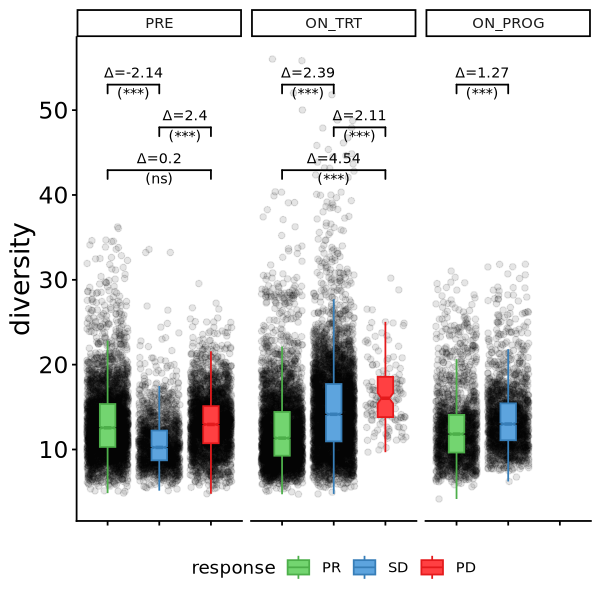

In [79]:
# Figure S5E
library(ggplot2)
library(ggpubr)
library(dplyr)
library(ggsignif)


# Define custom labels for specific comparisons
compute_wilcox_shift <- function(data, group_var, value_var) {
  comparisons <- combn(sort(unique(data[[group_var]])), 2, simplify = FALSE)
  
  results <- map(comparisons, function(comp) {
    test_data <- data %>% filter(!!sym(group_var) %in% comp)
    
    wilcox_res <- wilcox.test(
      reformulate(group_var, response = value_var),
      data = test_data,
      conf.int = TRUE
    )
    
    shift_param <- round(-1 * wilcox_res$estimate, 2) # shift estimate
    p_val <- wilcox_res$p.value

    n_tests <- 7
    signif_stars <- case_when(  # Bonferroni stars for SEVEN total tests
      p_val < 0.001/n_tests ~ "***",
      p_val < 0.01/n_tests  ~ "**",
      p_val < 0.05/n_tests  ~ "*",
      TRUE          ~ "ns"
    )
    
    comp <- as.character(comp)
    list(comparison = comp, label = sprintf("Δ=%s\n(%s)", shift_param, signif_stars))
  })
  
  # Convert into a named list for ggpubr
  list(
    comparisons = map(results, "comparison"),
    labels = map(results, "label")
  )
}
custom_labels <- cell_diversity %>%
  group_by(treatment.stage) %>%
  group_split() %>%
  map(~ compute_wilcox_shift(.x, "response", "diversity")) %>%
  set_names(unique(cell_diversity$treatment.stage))


# Base plot
p <- ggplot(cell_diversity, aes(response, diversity)) + 
  geom_jitter(alpha=0.1) +
  geom_boxplot(aes(fill=response, color=response), outlier.shape=NA, notch=TRUE, width=0.3) +
  theme_classic() +
  scale_fill_manual(values=colors_treatment_response %>% sapply(lighten)) +
  scale_color_manual(values=colors_treatment_response) +
  facet_grid(~treatment.stage) +
  diversity_plot_theme +
  theme(axis.text.x=element_blank(), axis.title.x=element_blank(), legend.position='bottom')

# Add custom annotations for each facet
for (stage in names(custom_labels)) {
  global_max <- max(cell_diversity$diversity, na.rm=T) * 0.9
  local_max <- max(cell_diversity %>% 
                   filter(treatment.stage==stage) %>% 
                   .$diversity, 
                   na.rm=T)

  p <- p + geom_signif(
    comparisons = custom_labels[[stage]]$comparisons,
    annotations = custom_labels[[stage]]$labels %>% unlist(),
    data = subset(cell_diversity, treatment.stage == stage),
    tip_length = 0.02,
    vjust = 0.6,
    textsize = 3,
    y_position = global_max - c(global_max*0, global_max*0.2, global_max*0.1)
  )
}

# Print final plot
w <- 5
h <- 5
options(repr.plot.width=w, repr.plot.height=h)
p


#! Fig S5E
ggsave('/home/ubuntu/data/cxcr4-pdac/figures/FigS5E.pdf', p, width=w, height=h, device=cairo_pdf)

In [ ]:
pre_diversity <- cell_diversity %>% filter(treatment.stage=='PRE')
on_diversity <- cell_diversity %>% filter(treatment.stage=='ON_TRT')
kruskal.test(pre_diversity, formula=diversity~response)
kruskal.test(on_diversity, formula=diversity~response)

Warning message in kruskal.test.default(pre_diversity, formula = diversity ~ response):
“some elements of 'x' are not numeric and will be coerced to numeric”



	Kruskal-Wallis rank sum test

data:  pre_diversity
Kruskal-Wallis chi-squared = 69500, df = 9, p-value < 2.2e-16


Warning message in kruskal.test.default(on_diversity, formula = diversity ~ response):
“some elements of 'x' are not numeric and will be coerced to numeric”



	Kruskal-Wallis rank sum test

data:  on_diversity
Kruskal-Wallis chi-squared = 76106, df = 9, p-value < 2.2e-16
